In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import healpy as hp
import numpy as np
import h5py, os
import matplotlib.pyplot as plt
import scipy.stats

from msfm.utils import files, maps

23-09-05 18:09:31    scales.py INF   Setting up healpy to run on 10 CPUs 


In [3]:
n_side = 512
n_pix = hp.nside2npix(n_side)

out_dir = "/Users/arne/polybox/_PhD/23_HS/Conferences & Presentations/Meetings/230901"

In [4]:
map_file = "/Users/arne/data/DESY3/CosmoGrid/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_nobaryons512.h5"

dg = []
z_bins = ['desy3maglim1', 'desy3maglim2', 'desy3maglim3', 'desy3maglim4']
with h5py.File(map_file, "r") as f:
    for z_bin in z_bins:
        dg.append(f[f"dg/{z_bin}"][:])

dg = np.stack(dg, axis=-1)
dg = (dg - np.mean(dg, axis=0, keepdims=True))/np.mean(dg, axis=0, keepdims=True)
print(dg.shape)

(3145728, 4)


# original

(3145728,)


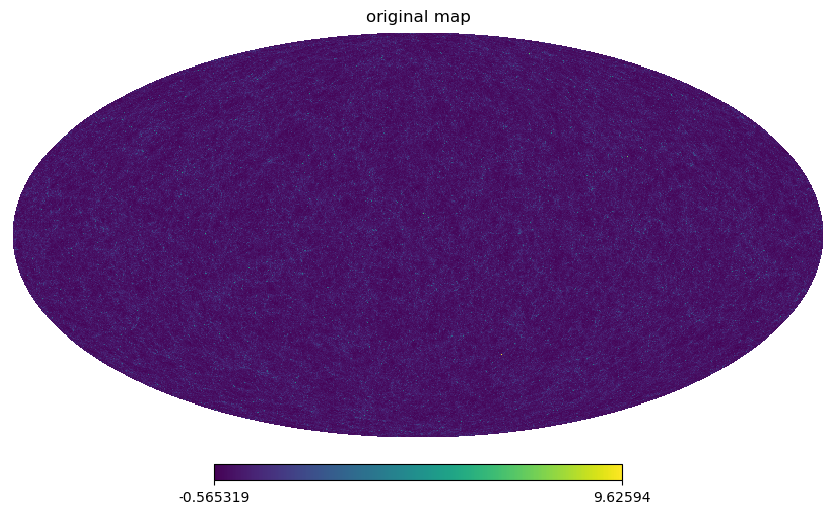

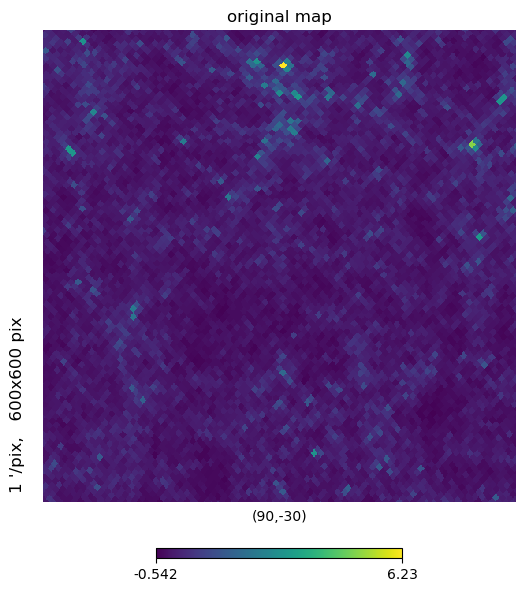

In [5]:
dg_example = dg[:,0]
hp.mollview(dg_example, nest=False, title="original map")
hp.gnomview(dg_example, nest=False, rot=(90, -30, 0), reso=1, xsize=600, ysize=600, title="original map")
print(dg_example.shape)

# data vector

In [6]:
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = files.load_pixel_file()

corresponding_pix = corresponding_pix_dict["maglim"]
cutout_pix = patches_pix_dict["maglim"][0]

print(data_vec_pix.shape, corresponding_pix.shape, cutout_pix.shape)

23-09-05 18:09:34     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
(464896,) (372677,) (372677,)


In [7]:
# dv = maps.map_to_data_vec(dg_example, len(data_vec_pix), corresponding_pix, cutout_pix)

In [8]:
data_vec = np.zeros(len(data_vec_pix), dtype=np.float32)
n_indices = corresponding_pix.shape[0]

assert corresponding_pix.shape == cutout_pix.shape

# assign
for i in range(n_indices):
    data_vec[corresponding_pix[i]] = dg_example[cutout_pix[i]]

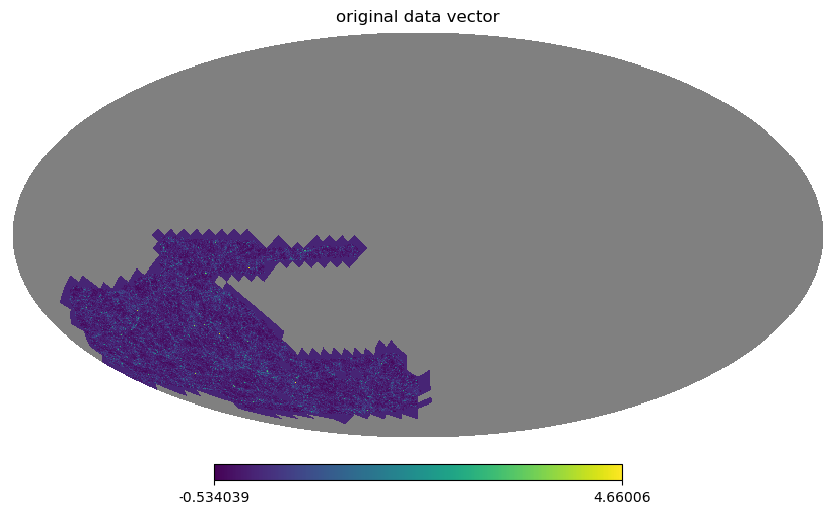

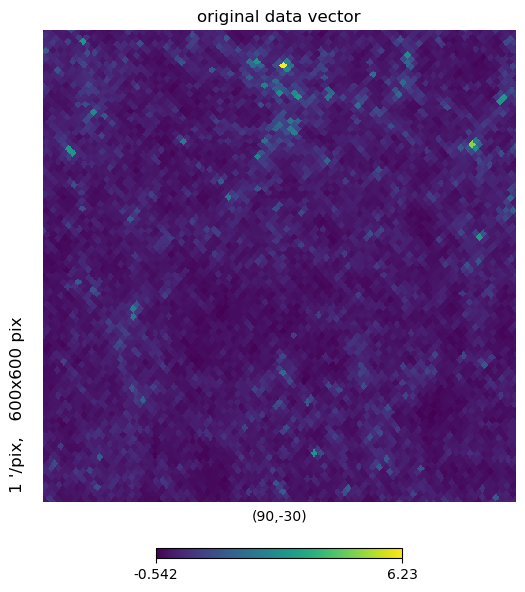

In [9]:
dv_full_sky = np.full(n_pix, hp.UNSEEN)
dv_full_sky[data_vec_pix] = data_vec

hp.mollview(dv_full_sky, nest=True, title="original data vector")
hp.gnomview(dv_full_sky, nest=True, rot=(90, -30, 0), reso=1, xsize=600, ysize=600, title="original data vector")

(array([5.02365369e-03, 1.61175556e-02, 3.74680838e-02, 8.27856265e-02,
        1.60442940e-01, 2.50868706e-01, 3.88495886e-01, 5.36902989e-01,
        6.96090015e-01, 8.88244769e-01, 1.05842104e+00, 1.21938727e+00,
        1.36570119e+00, 1.48208250e+00, 1.53954054e+00, 1.59783585e+00,
        1.61908172e+00, 1.60976703e+00, 1.59302152e+00, 1.54048247e+00,
        1.48511762e+00, 1.40358791e+00, 1.33576859e+00, 1.26522811e+00,
        1.08398934e+01, 1.11807693e+00, 1.03246549e+00, 9.65692763e-01,
        8.78197461e-01, 8.15506450e-01, 7.56059881e-01, 6.93892167e-01,
        6.14874280e-01, 5.90174650e-01, 5.53753160e-01, 4.77875058e-01,
        4.52233492e-01, 4.18533148e-01, 3.75622773e-01, 3.47155402e-01,
        3.21095199e-01, 2.87499515e-01, 2.79336077e-01, 2.43647204e-01,
        2.25331800e-01, 2.12877325e-01, 1.94771240e-01, 1.77711749e-01,
        1.73211393e-01]),
 array([-0.53003971, -0.50840544, -0.48677116, -0.46513689, -0.44350262,
        -0.42186834, -0.40023407, -0.

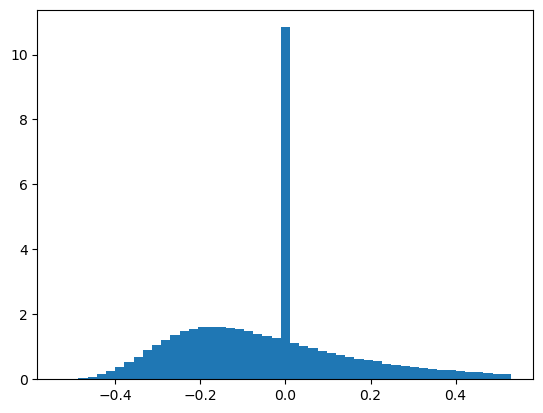

In [10]:
b_max = np.quantile(np.abs(dv_full_sky[dv_full_sky!=hp.UNSEEN]), 0.95)
b_min = - b_max
bins = np.linspace(b_min, b_max, 50)

fig, ax = plt.subplots()

ax.hist(dv_full_sky[dv_full_sky!=hp.UNSEEN], bins, density=True)

# Gaussian Random Field

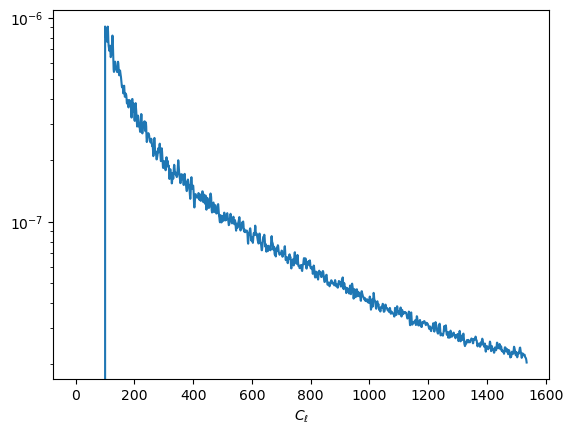

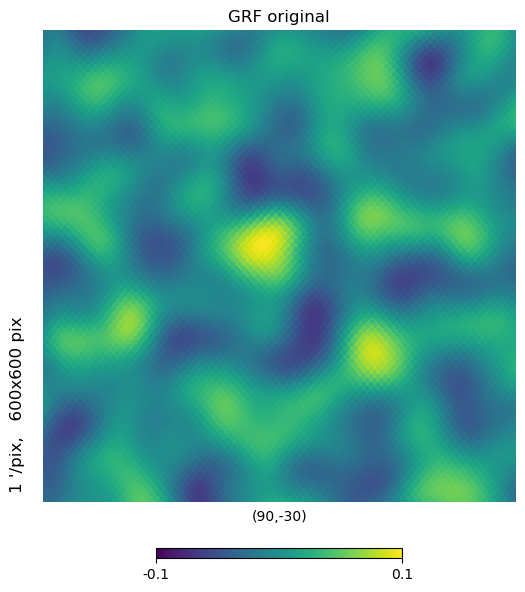

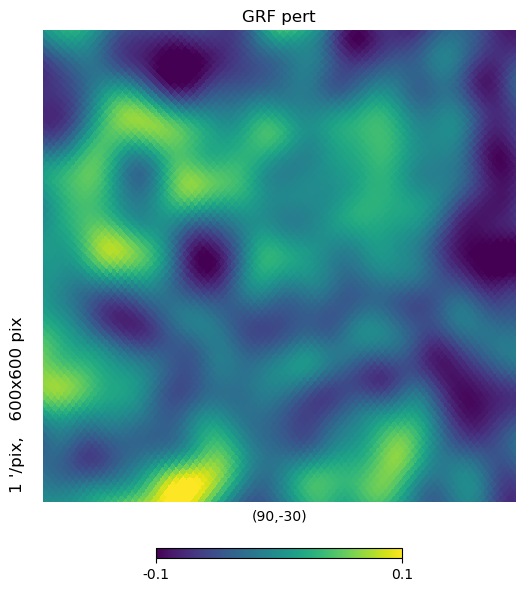

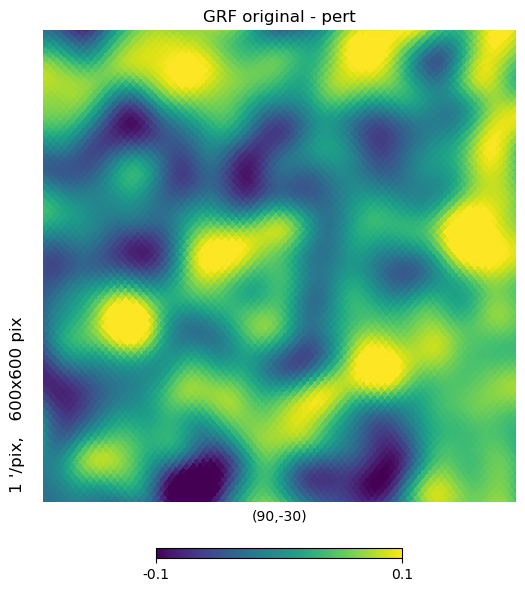

In [13]:
cl = hp.anafast(hp.reorder(dv_full_sky, n2r=True), alm=False, pol=False, use_pixel_weights=True)
cl[np.arange(0, 100)] = 0

fig, ax = plt.subplots()
ax.plot(cl)
ax.set(xlabel=r"$C_\ell$", xscale="linear", yscale="log")

np.random.seed(10)
grf_full_sky = hp.synfast(cl, nside=n_side, fwhm=np.pi / 200).astype(np.float32)
grf_full_sky = hp.reorder(grf_full_sky, r2n=True)

# minus perturbation
cl_m_pert = hp.anafast(hp.reorder(dv_full_sky - 0.1, n2r=True), alm=False, pol=False, use_pixel_weights=True)
# np.random.seed(10)
grf_m_pert_full_sky = hp.synfast(cl_m_pert, nside=n_side, fwhm=np.pi / 200).astype(np.float32)
grf_m_pert_full_sky = hp.reorder(grf_m_pert_full_sky, r2n=True)

vmin = -0.1
vmax = 0.1

# hp.mollview(grf_full_sky, nest=True, title="GRF original")
hp.gnomview(
    grf_full_sky, nest=True, rot=(90, -30, 0), reso=1, xsize=600, ysize=600, title="GRF original", min=vmin, max=vmax
)

# hp.mollview(grf_pert_full_sky, nest=True, title="GRF pert")
hp.gnomview(
    grf_m_pert_full_sky,
    nest=True,
    rot=(90, -30, 0),
    reso=1,
    xsize=600,
    ysize=600,
    title="GRF pert",
    min=vmin,
    max=vmax,
)

# hp.mollview(grf_full_sky - grf_pert_full_sky, nest=True, title="GRF original - pert")
hp.gnomview(
    grf_full_sky - grf_m_pert_full_sky,
    nest=True,
    rot=(90, -30, 0),
    reso=1,
    xsize=600,
    ysize=600,
    title="GRF original - pert",
    min=vmin,
    max=vmax,
)


In [15]:
dv_full_sky

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

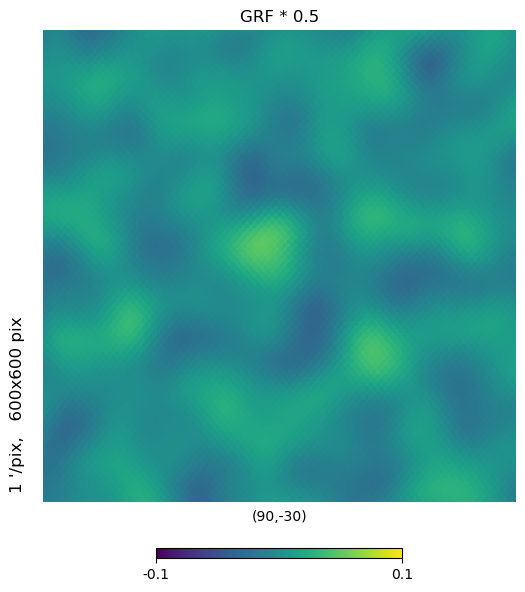

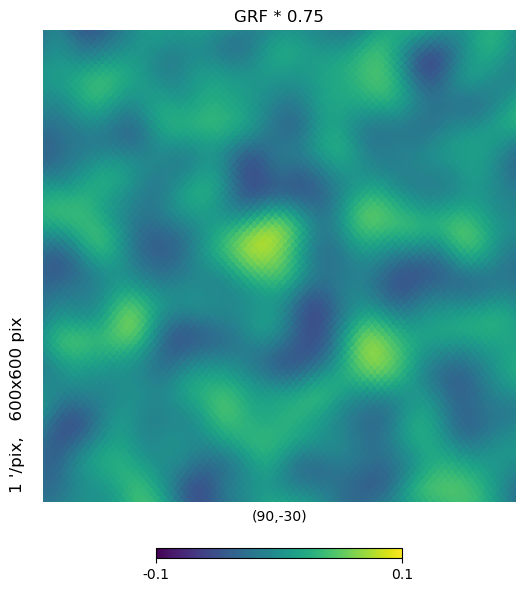

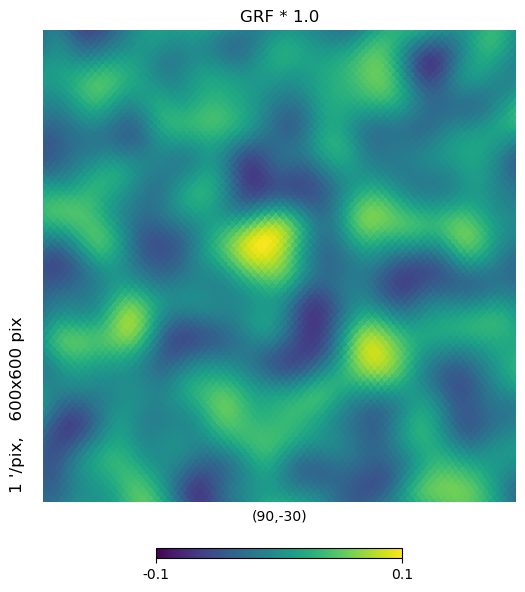

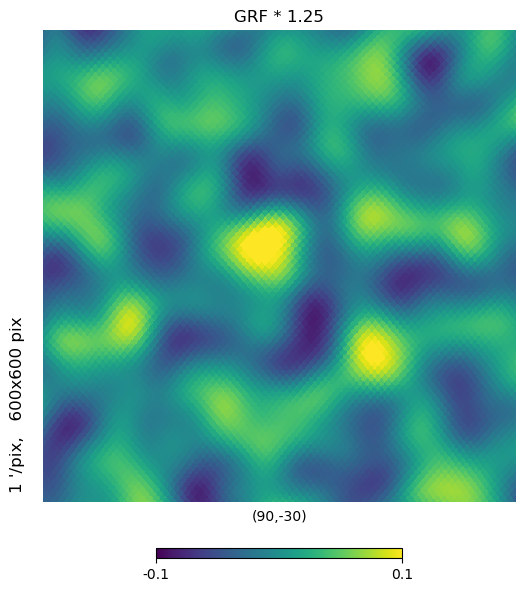

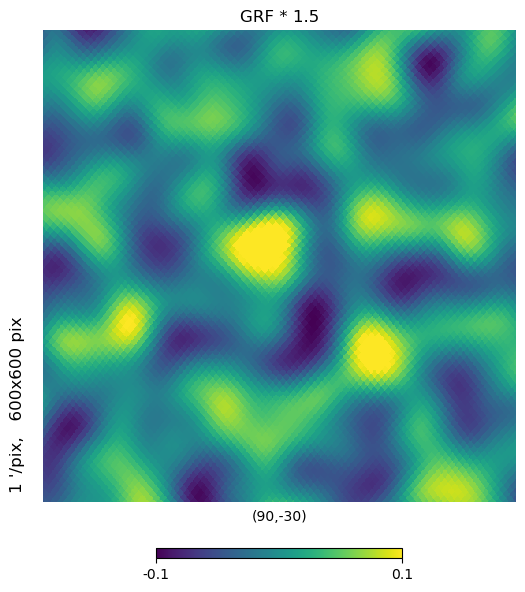

In [18]:
deltas = np.linspace(-0.5, 0.5, 5)

for i, delta in enumerate(deltas):
    np.random.seed(10)

    dv_pert_full_sky = dv_full_sky.copy()
    dv_pert_full_sky[dv_full_sky!=hp.UNSEEN] *= (1 + delta)
    cl = hp.anafast(hp.reorder(dv_pert_full_sky, n2r=True), alm=False, pol=False, use_pixel_weights=True)
    cl[np.arange(0, 100)] = 0

    grf_full_sky = hp.synfast(cl, nside=n_side, fwhm=np.pi / 200).astype(np.float32)
    grf_full_sky = hp.reorder(grf_full_sky, r2n=True)

    hp.gnomview(
        grf_full_sky, nest=True, rot=(90, -30, 0), reso=1, xsize=600, ysize=600, title=f"GRF * {1 + delta}", min=vmin, max=vmax
    )